In [2]:
import os
import io
import re
import math
import time
import pathlib
from typing import List, Dict, Any, Optional
from collections import defaultdict
from urllib.parse import urljoin

import requests
import urllib3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from requests_html import HTMLSession
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

## Data Acquisition


### NGER data acquisition

In [5]:
# NGER data set
BASE = "https://api.cer.gov.au/datahub-public/v1/api/ODataDataset/NGER/dataset"

# 你要的 10 个年度数据集 ID（含前缀 ID）
DATASET_IDS = [f"ID00{i}" for i in range(75, 84)] + ["ID0243"]  # 0075–0083 + 0243

# 通用请求头（提高兼容性）
HEADERS = {
    "Accept": "application/json",
    "User-Agent": "nger-data-notebook/1.1"
}

def _request(url: str, params=None, max_retry: int = 3):
    r = requests.get(url, params=params or {}, headers=HEADERS, timeout=30)
    retry = 0
    while r.status_code in (429, 500, 502, 503, 504) and retry < max_retry:
        time.sleep((retry + 1) * 1.5)
        r = requests.get(url, params=params or {}, headers=HEADERS, timeout=30)
        retry += 1
    r.raise_for_status()
    return r

def _extract_records(obj) -> List[Dict[str, Any]]:
    for key in ("value", "items", "results", "records"):
        if isinstance(obj, dict) and isinstance(obj.get(key), list):
            return obj[key]
    if isinstance(obj, list):
        return obj
    for v in (obj.values() if isinstance(obj, dict) else []):
        if isinstance(v, list):
            return v
    return []

def _get_next_link(d: Dict[str, Any]) -> str | None:
    for k in ("@odata.nextLink", "odata.nextLink", "nextLink", "next"):
        v = d.get(k) if isinstance(d, dict) else None
        if isinstance(v, str) and v:
            return v
    return None

def fetch_one_dataset(dataset_id: str,
                      page_size: int = 5000,
                      max_pages: int = 500,
                      sleep_sec: float = 0.2,
                      add_dataset_id: bool = True,
                      add_source_api: bool = False) -> pd.DataFrame:
    base_url = f"{BASE}/{dataset_id}"
    rows: List[Dict[str, Any]] = []

    # A) 直接请求并跟随 @odata.nextLink
    try:
        url, params, pages = base_url, {}, 0
        while True:
            data = _request(url, params).json()
            recs = _extract_records(data)
            if recs:
                rows.extend(recs)
            nxt = _get_next_link(data)
            if nxt and pages < max_pages:
                url, params, pages = nxt, {}, pages + 1
                time.sleep(sleep_sec)
                continue
            break
    except requests.HTTPError:
        rows = []

    # B) 若没有 nextLink，则用 $top/$skip 翻页
    if not rows:
        skip, pages = 0, 0
        while True:
            data = _request(base_url, {"$top": str(page_size), "$skip": str(skip)}).json()
            recs = _extract_records(data)
            if not recs:
                break
            rows.extend(recs)
            if len(recs) < page_size or pages >= max_pages:
                break
            skip += page_size
            pages += 1
            time.sleep(sleep_sec)

    df = pd.json_normalize(rows) if rows else pd.DataFrame()

    # >>> 新增：每年抓完就归一化 schema（只保留规范列）
    df = normalize_nger_schema(df, canonical_only=True)

    # 溯源列（可关）
    if add_dataset_id:
        df.insert(0, "source_dataset_id", dataset_id)
    if add_source_api:
        df.insert(1, "source_api", base_url)

    return df


def coalesce_year_column(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    year_like = [c for c in df.columns if re.search(r"(year|yr|reporting)", str(c), re.I)]
    for c in year_like:
        if any(k in c.lower() for k in ("report", "year", "yr")):
            return df.rename(columns={c: "reporting_year"})
    return df


def normalize_nger_schema(df: pd.DataFrame, canonical_only: bool = True) -> pd.DataFrame:
    """
    统一 NGER 各年度字段；grid_connected 保留原始文本（只做列名合并，不清洗）。
    """
    import numpy as np, pandas as pd, re

    if df.empty:
        return df

    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]

    # 逐行取候选列的第一个非空（跳过整列皆空）；numeric=True 时先转 float
    def _coalesce_first(frame: pd.DataFrame, candidates: list, numeric: bool = False) -> pd.Series:
        cols = [c for c in candidates if c in frame.columns and frame[c].notna().any()]
        if not cols:
            return pd.Series(np.nan if numeric else pd.NA, index=frame.index,
                             dtype=("float64" if numeric else "object"))
        tmp = frame[cols].copy()
        if numeric:
            for c in cols: tmp[c] = pd.to_numeric(tmp[c], errors="coerce")
            return tmp.bfill(axis=1).iloc[:, 0].astype("float64")
        return tmp.bfill(axis=1).iloc[:, 0].astype("object")

    # 简易列名选择器：把列名去空格/符号转小写后，要求包含一组关键词
    def _pick_cols(frame: pd.DataFrame, must_contain: list[str]) -> list[str]:
        out = []
        for c in frame.columns:
            s = re.sub(r'[\s\W_]+', '', str(c).lower())
            if all(k in s for k in must_contain):
                out.append(c)
        return out

    out = pd.DataFrame(index=df.index)

    # —— 实体名称：reporting_entity 合并 controlling_corporation —— #
    out["reporting_entity"] = _coalesce_first(
        df, ["reportingEntity", "reportingentity", "controllingcorporation", "Controlling Corporation"]
    )

    # —— 其他基础列 —— #
    out["facility_name"] = _coalesce_first(df, ["facilityName", "facilityname", "Facility Name"])
    out["type"]          = _coalesce_first(df, ["type", "Type"])
    out["state"]         = _coalesce_first(df, ["state", "State"]).astype(str).str.strip().str.upper()

    # —— 发电量 —— #
    out["electricity_production_gj"] = _coalesce_first(
        df, ["electricityProductionGJ", "electricityproductionGJ", "Electricity Production (GJ)"], numeric=True)
    out["electricity_production_mwh"] = _coalesce_first(
        df, ["electricityProductionMWh", "electricityProductionMwh", "electricityproductionMWh",
             "Electricity Production (Mwh)", "Electricity Production (MWh)"], numeric=True)
    mwh = out["electricity_production_mwh"]
    gj2mwh = out["electricity_production_gj"] / 3.6
    out["production_mwh_std"] = mwh.where(mwh.notna(), gj2mwh)

    # —— 排放总量 —— #
    out["scope1_tco2e"] = _coalesce_first(
        df, ["scope1tCO2e","totalscope1emissionstCO2e","Total Scope1 Emissions tCO2e","Scope 1 t CO2-e"], numeric=True)
    out["scope2_tco2e"] = _coalesce_first(
        df, ["scope2tCO2e","totalscope2emissionstCO2e","Total Scope2 Emissions tCO2e","Scope 2 t CO2-e"], numeric=True)
    out["total_emissions_tco2e"] = _coalesce_first(
        df, ["totalEmissions tCO2e","totalemissionstCO2e","totalEmissionsstCO2e","Total Emissions t CO2-e"], numeric=True)
    out["total_emissions_tco2e"] = out["total_emissions_tco2e"].fillna(out["scope1_tco2e"] + out["scope2_tco2e"])

    # —— 排放强度（关键词：emission + intensity + mwh） —— #
    intensity_cols = _pick_cols(df, ["emission", "intensity", "mwh"])
    out["emission_intensity_t_per_mwh"] = _coalesce_first(df, intensity_cols, numeric=True)

    gc_raw  = _coalesce_first(df, ["gridConnected", "gridconnected", "gridConnected2", "Grid Connected"])
    gc_norm = gc_raw.astype("string").str.strip()

    gc_out = pd.Series("N/A", index=df.index, dtype="string")
    mask_on  = gc_norm.str.casefold().eq("on")
    mask_off = gc_norm.str.casefold().eq("off")
    gc_out.loc[mask_on]  = "On"
    gc_out.loc[mask_off] = "Off"

    out["grid_connected"] = gc_out

    # 其余文本列
    out["grid"]         = _coalesce_first(df, ["grid", "Grid"])
    out["primary_fuel"] = _coalesce_first(df, ["primaryFuel", "primaryfuel", "Primary Fuel"])
    out["important_notes"] = _coalesce_first(df, ["importantNotes", "importantnotes", "Important Notes"])

    return out if canonical_only else pd.concat([df, out], axis=1)



In [6]:
frames = [fetch_one_dataset(dsid, add_dataset_id=True, add_source_api=False)
          for dsid in DATASET_IDS]
NGER_data = pd.concat(frames, ignore_index=True)
NGER_data = NGER_data.rename(columns={"state": "State"})
print(NGER_data.shape)
NGER_data.head(6)


(5942, 16)


,source_dataset_id,reporting_entity,facility_name,type,State,electricity_production_gj,electricity_production_mwh,production_mwh_std,scope1_tco2e,scope2_tco2e,total_emissions_tco2e,emission_intensity_t_per_mwh,grid_connected,grid,primary_fuel,important_notes
0,ID0075,ACCIONA ENERGY OCEANIA PTY LTD,Gunning Wind Farm,F,NSW,567719.0,157700.0,157700.0,19.0,293.0,312.0,0.00,On,NEM,Wind,N/A
1,ID0075,ACCIONA ENERGY OCEANIA PTY LTD,Royalla Solar Farm,F,ACT,213115.0,59199.0,59199.0,0.0,15.0,15.0,0.00,On,NEM,Solar,N/A
2,ID0075,ACCIONA ENERGY OCEANIA PTY LTD,Waubra Wind Farm,F,VIC,2461803.0,683834.0,683834.0,77.0,1144.0,1221.0,0.00,On,NEM,Wind,N/A
3,ID0075,ACCIONA ENERGY OCEANIA PTY LTD,Corporate Total,C,N/A,3242637.0,900733.0,900733.0,96.0,1452.0,1548.0,NaN,N/A,N/A,N/A,N/A
4,ID0075,AGL ENERGY LIMITED,Banimboola Hydro,F,VIC,137094.0,38082.0,38082.0,5.0,17.0,22.0,0.00,On,NEM,Hydro,N/A
5,ID0075,AGL ENERGY LIMITED,Bayswater Power Station,F,NSW,50275548.0,13965430.0,13965430.0,12253123.0,8306.0,12261429.0,0.88,On,NEM,Black Coal,N/A


### CER data acquisition


In [8]:
URL = "https://cer.gov.au/markets/reports-and-data/large-scale-renewable-energy-data#supply-data"

opts = Options()
opts.add_argument("--headless=new")   # 调试可注释
driver = webdriver.Chrome(options=opts)
driver.get(URL)

# 直接搜全页里目标前缀的链接
els = driver.find_elements(By.CSS_SELECTOR, 'a[href*="/document/power-stations-and-projects-"]')
hrefs = [urljoin(URL, e.get_attribute("href")) for e in els]
driver.quit()

# 去重并按关键词分类
seen = set()
hrefs = [u for u in hrefs if not (u in seen or seen.add(u))]
links = {k: next((u for u in hrefs if k in u.lower()), None)
         for k in ["accredited", "committed", "probable"]}

print(links) 

{'accredited': 'https://cer.gov.au/document/power-stations-and-projects-accredited', 'committed': 'https://cer.gov.au/document/power-stations-and-projects-committed', 'probable': 'https://cer.gov.au/document/power-stations-and-projects-probable'}


In [9]:

# 请求头
UA = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "text/csv,application/octet-stream,*/*",
    "Referer": "https://cer.gov.au/markets/reports-and-data/large-scale-renewable-energy-data#supply-data",
}

# 下载 CSV
def fetch_csv(url: str) -> pd.DataFrame:
    r = requests.get(url, headers=UA, allow_redirects=True, timeout=60)
    r.raise_for_status()
    return pd.read_csv(io.BytesIO(r.content), encoding="utf-8-sig")

# 列名映射
CANON_MAP_CI = {
    "fuel source": "Fuel Source",
    "fuel source (s)": "Fuel Source",
    "mw capacity": "Mw Capacity",
    "installed capacity (mw)": "Mw Capacity",
    "state": "State",
    "postcode": "Postcode",
    "accreditation code": "Accreditation code",
    "accreditation start date": "Accreditation start date",
    "approval date": "Approval date",
    "committed date": "Committed Date (Month/Year)",
    "committed date (month/year)": "Committed Date (Month/Year)",
}

# 列名标准化
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = []
    for c in df.columns:
        key = re.sub(r"\s+", " ", str(c)).strip().lower()
        key = key.replace("（", "(").replace("）", ")")
        new_cols.append(CANON_MAP_CI.get(key, c))  # 命中则替换
    out = df.copy()
    out.columns = new_cols
    return out

# 合并重复列
def coalesce_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    for col in pd.unique(df.columns):
        same = [c for c in df.columns if c == col]
        out[col] = df[same].bfill(axis=1).iloc[:, 0] if len(same) > 1 else df[same[0]]
    return out

# 读取一个表格
def prepare_one(url: str, status: str | None = None) -> pd.DataFrame:
    df = fetch_csv(url)
    df = normalize_columns(df)
    df = coalesce_duplicate_columns(df)
    
    if status is not None:
        df["status"] = status
    return df

# -------- 在拿到 links 后执行 --------
# accredited 单独，不加 status
df_accredited = prepare_one(links["accredited"], status=None)

# committed + probable，合并后带 status
df_committed = prepare_one(links["committed"], status="committed")
df_probable  = prepare_one(links["probable"],  status="probable")
df_committed_probable = pd.concat([df_committed, df_probable], ignore_index=True)


# 看前几行
display(df_accredited.head())
display(df_committed_probable.head())


,Accreditation code,Power station name,State,Postcode,Mw Capacity,Fuel Source,Accreditation start date,Approval date
0,SRPXQLE8,"Laura Johnson Home, Townview - Solar w SGU - QLD",QLD,4825,0.2265,Solar,15/10/2024,13/01/2025
1,SRPYNS39,Leppington - Solar - NSW,NSW,2179,0.7320,Solar,22/11/2024,13/01/2025
2,SRPYNS58,Quakers Hillside Care Community - Solar w SGU ...,NSW,2763,0.1996,Solar,19/12/2024,13/01/2025
3,SRPXVCN4,Rest Nominees - Solar wSGU - VIC,VIC,3008,0.1188,Solar,20/09/2024,13/01/2025
4,SRPXQLF9,Retail First Mt Ommaney-Solar-QLD,QLD,4074,1.0004,Solar,29/10/2024,13/01/2025


,Project Name,State,Mw Capacity,Fuel Source,Committed Date (Month/Year),status
0,East Rockingham Resource Recovery Facility,WA,29.0,Biomass,Dec-2019,committed
1,Mangalore Renewable Energy Project,VIC,5.0,Solar,Sep-2021,committed
2,Orange Community Renewable Energy Park,NSW,5.0,Solar,Jul-2022,committed
3,Moorebank Logistics Park,NSW,60.0,Solar,Sep-2022,committed
4,Wangaratta Solar Farm,VIC,40.0,Solar,Jul-2023,committed


### ABS Data Acquisition

In [11]:
URL  = "https://www.abs.gov.au/methodologies/data-region-methodology/2011-24#data-downloads"
BASE = "https://www.abs.gov.au/methodologies/data-region-methodology/2011-24/"

UA = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "text/html,application/xhtml+xml",
    "Referer": "https://www.abs.gov.au/",
}

# 1) 抓页面
resp = requests.get(URL, headers=UA, timeout=30)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, "html.parser")

# 2) 找 aria-label 含 “Economy and industry” 的 <a>，并标准化为绝对链接
matches = []
for a in soup.find_all("a", href=True):
    label = (a.get("aria-label") or "").strip()
    if re.search(r"\beconomy and industry\b", label, flags=re.I):
        href_abs = urljoin(URL, a["href"])
        if href_abs.startswith(BASE):
            matches.append((label, href_abs))

# 去重并打印
seen = set()
links = [(lab, href) for lab, href in matches if not (href in seen or seen.add(href))]

print(links)



[('Download - Economy and industry, ASGS and LGA, 2011, 2016-2024 xlsx 18.75 MB', 'https://www.abs.gov.au/methodologies/data-region-methodology/2011-24/14100DO0003_2011-24.xlsx')]


In [12]:
def _pick_sheet(sheets: dict) -> pd.DataFrame:
    """从所有工作表里挑出 Table 1（或名字含 economy/industry 的）"""
    # 优先精确命名
    for k in sheets:
        if re.search(r'\btable\s*1\b', str(k), flags=re.I):
            return sheets[k]
    # 次选：名字里带 Economy / Industry
    for k in sheets:
        if re.search(r'economy|industry', str(k), flags=re.I):
            return sheets[k]
    # 否则取第一个
    first = next(iter(sheets))
    return sheets[first]

def load_abs_table1(file_like_or_path, sheet=None, max_header_rows=5, joiner=" - "):
    # --- 载入 ---
    if isinstance(file_like_or_path, (bytes, bytearray, io.BytesIO)):
        data = io.BytesIO(file_like_or_path if isinstance(file_like_or_path, (bytes, bytearray))
                          else file_like_or_path.getvalue())
    elif isinstance(file_like_or_path, str) and file_like_or_path.startswith(("http://","https://")):
        r = requests.get(file_like_or_path, timeout=60); r.raise_for_status()
        data = io.BytesIO(r.content)
    else:
        data = file_like_or_path

    xls = pd.ExcelFile(data, engine="openpyxl")
    sheet_names = xls.sheet_names if sheet is None else [sheet]

    def _norm_cell(x):
        if pd.isna(x): return ""
        return re.sub(r"\s+"," ", str(x)).strip().lower()

    target_sheet = raw = None
    header_row = None

    # --- 自动找含 Code/Label 的表头行 ---
    for sh in sheet_names:
        tmp = pd.read_excel(xls, sheet_name=sh, header=None, dtype=object, engine="openpyxl")
        norm = tmp.map(_norm_cell)  # ← 替代 applymap
        found = None
        for i in range(norm.shape[0]):
            row_vals = set(norm.iloc[i].tolist())
            if "code" in row_vals and "label" in row_vals:
                found = i; break
        if found is not None:
            target_sheet, raw, header_row = sh, tmp, found
            break
    if raw is None:
        raise RuntimeError("没找到包含 Code/Label 的表头行；请检查 sheet 或显式传入 sheet=")

    # --- 取表头块（表头行 + 上方若干行）---
    used = [header_row]; up = header_row-1; steps = 0
    while up >= 0 and steps < max_header_rows and not raw.iloc[up].isna().all():
        used.append(up); up -= 1; steps += 1
    used = sorted(used)
    top = raw.iloc[used].copy()

    # 修复合并单元格并清理文本
    top = (top.replace(r"^\s*$", np.nan, regex=True)
             .ffill(axis=1).fillna("").astype(str)
             .map(lambda s: re.sub(r"\s+"," ", s).strip()))  # ← 替代 applymap

    # 生成单行列名
    new_cols = []
    for col_vals in top.T.values:
        parts = [p for p in col_vals if p and not p.lower().startswith("unnamed:")]
        new_cols.append(joiner.join(parts) if parts else "")
    df = raw.iloc[header_row+1:].copy()
    df.columns = new_cols

    # 去全空/无名列
    keep = [c for c in df.columns if c and not df[c].isna().all()]
    df = df[keep]

    # 统一 Code/Label/Year
    mapping = {}
    for c in df.columns:
        cl = c.lower()
        if cl == "code" or cl.endswith(joiner+"code"):   mapping[c] = "Code"
        elif cl == "label" or cl.endswith(joiner+"label"): mapping[c] = "Label"
        elif cl == "year" or cl.endswith(joiner+"year"): mapping[c] = "Year"
    if mapping: df = df.rename(columns=mapping)
    if "Year" in df.columns:
        df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")

    # 度量列数值化（不再使用 errors='ignore'）
    def _to_numeric_if_any(s: pd.Series) -> pd.Series:
    # 统一到 pandas StringDtype，避免 replace/astype 引发 downcasting 提醒
        s_str = pd.Series(s, copy=False).astype("string")

    # 清洗：去千分位、统一负号、把占位符变成缺失
        s_str = (
        s_str.str.replace(",", "", regex=False)       # "12,345" -> "12345"
             .str.replace("\u2212", "-", regex=False) # Unicode 负号 -> 普通 "-"
             .str.strip()
             .where(~s_str.isin(["-", "…", ""]), pd.NA)  # -, …, 空串 -> NA
    )

    # 能转成数字就用，全部是文本则保留原列
        conv = pd.to_numeric(s_str, errors="coerce")
        return conv if conv.notna().any() else s

    measure_like = [c for c in df.columns if c not in {"Code", "Label", "Year"}]
    for c in measure_like:
        df[c] = _to_numeric_if_any(df[c])
    return df

xlsx_url = links[0][1]   # 或者直接贴 ABS 的下载 URL
ABS_data = load_abs_table1(xlsx_url)
print(ABS_data.shape)
ABS_data.head(10)

(29097, 127)


,Code,Label,Year,Number of businesses - at 30 June - Number of non-employing businesses,Number of businesses - at 30 June - Number of employing businesses: 1-4 employees,Number of businesses - at 30 June - Number of employing businesses: 5-19 employees,Number of businesses - at 30 June - Number of employing businesses: 20 or more employees,Number of businesses - at 30 June - Total number of businesses,Business entries - year ended 30 June - Number of non-employing business entries,Business entries - year ended 30 June - Number of employing business entries: 1-4 employees,...,Estimated dwelling stock - as at June quarter - Houses - total (no.),Estimated dwelling stock - as at June quarter - Townhouses - additions (no.),Estimated dwelling stock - as at June quarter - Townhouses - removals (no.),Estimated dwelling stock - as at June quarter - Townhouses - total (no.),Estimated dwelling stock - as at June quarter - Apartments - additions (no.),Estimated dwelling stock - as at June quarter - Apartments - removals (no.),Estimated dwelling stock - as at June quarter - Apartments - total (no.),Estimated dwelling stock - as at June quarter - Total dwelling additions (no.),Estimated dwelling stock - as at June quarter - Total dwelling removals (no.),Estimated dwelling stock - as at June quarter - Total dwellings (no.)
7,AUS,Australia,2011,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
8,AUS,Australia,2016,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9,AUS,Australia,2017,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,7279135,31729,480,1261457,73838,564,1464325,218884,19586,10022775
10,AUS,Australia,2018,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,7371408,33346,919,1293884,66330,605,1530050,213652,23181,10213246
11,AUS,Australia,2019,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,7472853,32571,712,1325743,60705,985,1589770,215556,22394,10406408
12,AUS,Australia,2020,1441105,599516,213218,60609,2314448,<NA>,<NA>,...,7556401,27873,842,1352774,58921,1255,1647436,192514,24220,10574702
13,AUS,Australia,2021,1410049,711364,220427,60414,2402254,254149,102564,...,7639265,27296,703,1379367,49548,1325,1695659,182405,24689,10732418
14,AUS,Australia,2022,1521428,727457,226968,63871,2539724,325373,106697,...,7729884,23166,743,1401790,34213,487,1729385,174147,27216,10879349
15,AUS,Australia,2023,1585693,703467,231259,69454,2589873,297302,99446,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
16,AUS,Australia,2024,1663837,693558,232200,73403,2662998,325420,99864,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


## Data Integration and Cleaning


### NGER Exploration and Pre-processing

In [15]:
#数据类型转换

In [16]:
NGER_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   source_dataset_id             5942 non-null   object 
 1   reporting_entity              5942 non-null   object 
 2   facility_name                 5942 non-null   object 
 3   type                          5942 non-null   object 
 4   State                         5942 non-null   object 
 5   electricity_production_gj     5938 non-null   float64
 6   electricity_production_mwh    5938 non-null   float64
 7   production_mwh_std            5938 non-null   float64
 8   scope1_tco2e                  3871 non-null   float64
 9   scope2_tco2e                  3871 non-null   float64
 10  total_emissions_tco2e         3871 non-null   float64
 11  emission_intensity_t_per_mwh  4830 non-null   float64
 12  grid_connected                5942 non-null   string 
 13  gri

In [17]:
string_cols = [
    "source_dataset_id", "reporting_entity", "facility_name", 
    "type", "State", "grid_connected", "grid", 
    "primary_fuel", "important_notes"
]
NGER_data[string_cols] = NGER_data[string_cols].astype("string")

# 转换为 Int32（可空整数类型）
int_cols = [
    "electricity_production_gj", "electricity_production_mwh",
    "scope1_tco2e", "scope2_tco2e", "total_emissions_tco2e"
]
for c in int_cols:
    NGER_data[c] = pd.to_numeric(NGER_data[c], errors="coerce").astype("Int32")

In [18]:
#数据检查-发现有很多“ ”“-” ”N/A“没有规范过的空值 统一规范成了<NA>

In [19]:
exclude_cols = {"source_dataset_id", "important_notes"}
cols_to_check = [c for c in NGER_data.columns if c not in exclude_cols]

# 对每列跑 value_counts
for col in cols_to_check:
    print(f"\n=== {col} ===")
    print(NGER_data[col].value_counts(dropna=False).head(10)) 


=== reporting_entity ===
reporting_entity
POWER AND WATER CORPORATION                      461
HYDRO-ELECTRIC CORPORATION                       329
AGL ENERGY LIMITED                               313
CK WILLIAM AUSTRALIA HOLDINGS PTY LTD            308
LMS ENERGY PTY LTD                               261
ENERGY QUEENSLAND LIMITED                        245
ORIGIN ENERGY LIMITED                            197
ELECTRICITY GENERATION AND RETAIL CORPORATION    136
REGIONAL POWER CORPORATION                       129
SPIC PACIFIC ENERGY PTY LTD                      102
Name: count, dtype: Int64

=== facility_name ===
facility_name
Corporate Total               1056
Facility                        17
Daandine Power Station          14
Barron Gorge Power Station      11
Waterloo Wind Farm              11
Vales Point Power Station       11
Solomon Power Station           11
Kareeya Power Station           11
Bayswater Power Station         11
Royalla Solar Farm              11
Name: count, d

In [20]:
cols = ["type", "State", "grid", "primary_fuel","important_notes"]

# 1) 统一为 string 并去两端空白
NGER_data[cols] = NGER_data[cols].apply(lambda s: s.astype("string").str.strip())

# 2) 把“假缺失值”统一成 NA（大小写不敏感）
#    匹配：空串、连字符-、N/A、NA、<NA>、None、Nil
missing_pat = r"(?i)^(?:|-|n/?a|<na>|none|nil)$"   # (?i) 大小写不敏感
NGER_data[cols] = NGER_data[cols].replace(missing_pat, pd.NA, regex=True)

# 3) 可选：分类字段规范化（按你的口径调整）
# state → 大写州代码
# NGER_data["state"] = NGER_data["state"].str.upper()

# grid → 统一空白、大小写与常见拼写
NGER_data["grid"] = (
    NGER_data["grid"]
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
      .str.title()
      .replace({
          "Off Grid": "Off-grid",
          "Dkis": "DKIS",
          "Nwis": "NWIS",
          "Mt Isa": "Mt Isa",
      })
)

# 4) 再确保 dtype 为 string（避免后续操作把类型冲回 object）
NGER_data[cols] = NGER_data[cols].astype("string")

NGER_data["grid_connected"] = NGER_data["grid_connected"].replace("N/A", pd.NA)



In [21]:
#检查是否有异常数据 即出现负数的情况

In [22]:
num_cols = [
    "electricity_production_gj", "electricity_production_mwh", "production_mwh_std",
    "scope1_tco2e", "scope2_tco2e", "total_emissions_tco2e",
    "emission_intensity_t_per_mwh"
]

# 统计每列的负值和零值数量
check_neg_zero = {}
for c in num_cols:
    col = pd.to_numeric(NGER_data[c], errors="coerce")
    check_neg_zero[c] = {
        "count_total": col.notna().sum(),
        "count_zero": (col == 0).sum(),
        "count_negative": (col < 0).sum(),
        "min_value": col.min(),
        "max_value": col.max(),
    }

# 转换为 DataFrame 方便看
check_df = pd.DataFrame(check_neg_zero).T
print(check_df)

                              count_total  count_zero  count_negative  \
electricity_production_gj          5938.0        71.0             0.0   
electricity_production_mwh         5938.0        72.0             0.0   
production_mwh_std                 5938.0        72.0             0.0   
scope1_tco2e                       3871.0       522.0             0.0   
scope2_tco2e                       3871.0      1462.0             0.0   
total_emissions_tco2e              3871.0       177.0             0.0   
emission_intensity_t_per_mwh       4830.0      1762.0             0.0   

                              min_value     max_value  
electricity_production_gj           0.0  8.189245e+08  
electricity_production_mwh          0.0  2.274790e+08  
production_mwh_std                  0.0  2.274790e+08  
scope1_tco2e                        0.0  1.432884e+08  
scope2_tco2e                        0.0  2.072018e+06  
total_emissions_tco2e               0.0  1.453605e+08  
emission_intensity_t_pe

In [23]:
#查看缺失值情况

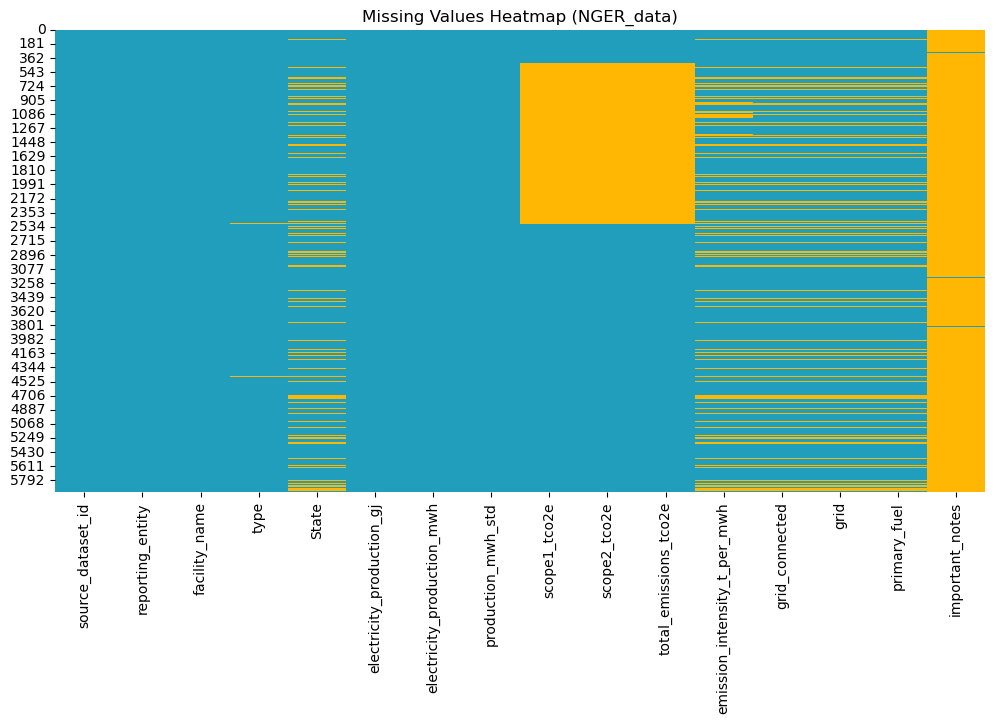

In [24]:
plt.figure(figsize=(12,6))
sns.heatmap(NGER_data.isnull(), cbar=False, cmap=["#219ebc", "#ffb703"])
plt.title("Missing Values Heatmap (NGER_data)")
plt.show()

In [25]:
NGER_data.isnull().mean().round(3) * 100 

source_dataset_id                0.0
reporting_entity                 0.0
facility_name                    0.0
type                             0.1
State                           17.9
electricity_production_gj        0.1
electricity_production_mwh       0.1
production_mwh_std               0.1
scope1_tco2e                    34.9
scope2_tco2e                    34.9
total_emissions_tco2e           34.9
emission_intensity_t_per_mwh    18.7
grid_connected                  17.9
grid                            17.9
primary_fuel                    17.9
important_notes                 99.4
dtype: float64

In [26]:
NGER_data.head(5)

,source_dataset_id,reporting_entity,facility_name,type,State,electricity_production_gj,electricity_production_mwh,production_mwh_std,scope1_tco2e,scope2_tco2e,total_emissions_tco2e,emission_intensity_t_per_mwh,grid_connected,grid,primary_fuel,important_notes
0,ID0075,ACCIONA ENERGY OCEANIA PTY LTD,Gunning Wind Farm,F,NSW,567719,157700,157700.0,19,293,312,0.0,On,Nem,Wind,<NA>
1,ID0075,ACCIONA ENERGY OCEANIA PTY LTD,Royalla Solar Farm,F,ACT,213115,59199,59199.0,0,15,15,0.0,On,Nem,Solar,<NA>
2,ID0075,ACCIONA ENERGY OCEANIA PTY LTD,Waubra Wind Farm,F,VIC,2461803,683834,683834.0,77,1144,1221,0.0,On,Nem,Wind,<NA>
3,ID0075,ACCIONA ENERGY OCEANIA PTY LTD,Corporate Total,C,<NA>,3242637,900733,900733.0,96,1452,1548,NaN,<NA>,<NA>,<NA>,<NA>
4,ID0075,AGL ENERGY LIMITED,Banimboola Hydro,F,VIC,137094,38082,38082.0,5,17,22,0.0,On,Nem,Hydro,<NA>


### CER Exploration and Pre-processing

In [28]:
#转换数据类型

In [29]:
df_accredited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Accreditation code        280 non-null    object 
 1   Power station name        280 non-null    object 
 2   State                     280 non-null    object 
 3   Postcode                  280 non-null    int64  
 4   Mw Capacity               280 non-null    float64
 5   Fuel Source               280 non-null    object 
 6   Accreditation start date  280 non-null    object 
 7   Approval date             280 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 17.6+ KB


In [30]:
str_cols = ["Accreditation code", "Power station name", "State", "Postcode", "Fuel Source"]
df_accredited[str_cols] = df_accredited[str_cols].astype("string")

# 2) 转换日期列
date_cols = ["Accreditation start date", "Approval date"]
for col in date_cols:
    df_accredited[col] = pd.to_datetime(df_accredited[col], dayfirst=True, errors="coerce")


In [31]:
df_committed_probable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Project Name                 84 non-null     object 
 1   State                        84 non-null     object 
 2   Mw Capacity                  84 non-null     float64
 3   Fuel Source                  84 non-null     object 
 4   Committed Date (Month/Year)  35 non-null     object 
 5   status                       84 non-null     object 
dtypes: float64(1), object(5)
memory usage: 4.1+ KB


In [32]:
str_cols = ["Project Name", "State", "Fuel Source", "status"]
df_committed_probable[str_cols] = df_committed_probable[str_cols].astype("string")

col = "Committed Date (Month/Year)"

# 1) 清洗：转字符串，去空格，替换各种连字符为标准 '-'
dash_chars = r"[\u2010-\u2015\u2212\uFE58\uFE63\uFF0D]"  # 常见的奇怪横杠
cleaned = (
    df_committed_probable[col]
    .astype("string")
    .str.normalize("NFKC")
    .str.replace(dash_chars, "-", regex=True)
    .str.strip()
)

# 2) 尝试多种格式解析
dt = pd.to_datetime(cleaned, format="%b-%y", errors="coerce")   # Dec-19
mask = dt.isna()
if mask.any():
    dt.loc[mask] = pd.to_datetime(cleaned[mask], format="%b-%Y", errors="coerce")  # Dec-2019
mask = dt.isna()
if mask.any():
    dt.loc[mask] = pd.to_datetime(cleaned[mask], errors="coerce")  # 兜底自动推断

# 3) 覆盖回原列
df_committed_probable[col] = dt

In [33]:
#检查是否出现inconsistent value answer:没发现

In [34]:
# 定义可能的不一致空值
na_values = ["", " ", "-", "N/A", "<NA>", "na", "NA", "n/a"]

# 先检查：每列的 value_counts 前几项
for col in df_accredited.columns:
    print(f"\n=== {col} ===")
    print(df_accredited[col].value_counts(dropna=False).head(10))


=== Accreditation code ===
Accreditation code
SRPXQLE8    1
SRPYNS57    1
SRPXVCN4    1
SRPXQLF9    1
SRPXQLG3    1
SRPVTA25    1
SRPVSAY5    1
SRPYNS52    1
SRPYNS56    1
SRPVSAY6    1
Name: count, dtype: Int64

=== Power station name ===
Power station name
Laura Johnson Home, Townview - Solar w SGU - QLD                       1
Dalwood Children's Home - Solar - NSW                                  1
Rest Nominees - Solar wSGU - VIC                                       1
Retail First Mt Ommaney-Solar-QLD                                      1
Woolworths HCFDC Heathwood - Solar - QLD                               1
Woolworths Kings Meadow 7210 - Solar - TAS                             1
CLAYTON CHURCH HOMES INC- ELIZABETH PARK - Solar w SGU - SA            1
Woolworths DC Moorebank RDC 7950 - Solar - NSW                         1
Lindt & Sprungli (Australia) Pty Ltd - 1017.9kW - Solar w SGU - NSW    1
CLAYTON CHURCH HOMES INC- Prospect-Solar-W-SGU-SA                      1
Name: coun

In [35]:
for col in df_committed_probable.columns:
    print(f"\n=== {col} ===")
    print(df_committed_probable[col].value_counts(dropna=False).head(10))


=== Project Name ===
Project Name
East Rockingham Resource Recovery Facility    1
Uungula Wind Farm                             1
Orange Community Renewable Energy Park        1
Moorebank Logistics Park                      1
Wangaratta Solar Farm                         1
Kidston Pumped Hydro Storage Project          1
New England Solar Farm - Stage 2              1
Bellevue Gold Hybrid Power Station (Wind)     1
Glenellen solar project                       1
Forest Glen Solar Farm                        1
Name: count, dtype: Int64

=== State ===
State
NSW    23
QLD    22
VIC    19
WA     11
SA      7
TAS     2
Name: count, dtype: Int64

=== Mw Capacity ===
Mw Capacity
150.0    4
250.0    4
100.0    3
300.0    3
5.0      3
4.5      2
288.0    2
700.0    2
120.0    2
77.0     2
Name: count, dtype: int64

=== Fuel Source ===
Fuel Source
Solar      58
Wind       24
Biomass     1
Hydro       1
Name: count, dtype: Int64

=== Committed Date (Month/Year) ===
Committed Date (Month/Year)
NaT

In [36]:
# 检查是否出现负值 不符合逻辑的情况 answer:没有

In [37]:
print("=== 描述性统计 ===")
print(df_accredited["Mw Capacity"].describe())

# 2) 找出负值（如果业务上不可能出现负数）
neg_vals = df_accredited[df_accredited["Mw Capacity"] < 0]
print("\n=== 负值检查 ===")
print(neg_vals)

=== 描述性统计 ===
count    280.000000
mean       9.262732
std       55.908664
min        0.118800
25%        0.203000
50%        0.327500
75%        0.671500
max      520.393000
Name: Mw Capacity, dtype: float64

=== 负值检查 ===
Empty DataFrame
Columns: [Accreditation code, Power station name, State, Postcode, Mw Capacity, Fuel Source, Accreditation start date, Approval date]
Index: []


In [38]:

print("=== 描述性统计 ===")
print(df_committed_probable["Mw Capacity"].describe())

# 2) 找出负值（如果业务上不可能出现负数）
neg_vals = df_committed_probable[df_committed_probable["Mw Capacity"] < 0]
print("\n=== 负值检查 ===")
print(neg_vals)

=== 描述性统计 ===
count      84.000000
mean      250.749405
std       285.485551
min         4.500000
25%        63.500000
50%       150.000000
75%       300.000000
max      1400.000000
Name: Mw Capacity, dtype: float64

=== 负值检查 ===
Empty DataFrame
Columns: [Project Name, State, Mw Capacity, Fuel Source, Committed Date (Month/Year), status]
Index: []


In [39]:
#检查缺失值情况

In [40]:
missing = df_accredited.isna().sum().reset_index()
missing.columns = ["column", "missing_count"]
missing["missing_percent"] = missing["missing_count"] / len(df_accredited) * 100

print(missing)


                     column  missing_count  missing_percent
0        Accreditation code              0              0.0
1        Power station name              0              0.0
2                     State              0              0.0
3                  Postcode              0              0.0
4               Mw Capacity              0              0.0
5               Fuel Source              0              0.0
6  Accreditation start date              0              0.0
7             Approval date              0              0.0


In [41]:
missing = df_committed_probable.isna().sum().reset_index()
missing.columns = ["column", "missing_count"]
missing["missing_percent"] = missing["missing_count"] / len(df_committed_probable) * 100

print(missing)


                        column  missing_count  missing_percent
0                 Project Name              0         0.000000
1                        State              0         0.000000
2                  Mw Capacity              0         0.000000
3                  Fuel Source              0         0.000000
4  Committed Date (Month/Year)             49        58.333333
5                       status              0         0.000000


In [42]:
df_committed_probable = df_committed_probable.rename(
    columns={"Committed Date (Month/Year)": "Committed Date"}
)

df_accredited.head(5)


,Accreditation code,Power station name,State,Postcode,Mw Capacity,Fuel Source,Accreditation start date,Approval date
0,SRPXQLE8,"Laura Johnson Home, Townview - Solar w SGU - QLD",QLD,4825,0.2265,Solar,2024-10-15,2025-01-13
1,SRPYNS39,Leppington - Solar - NSW,NSW,2179,0.7320,Solar,2024-11-22,2025-01-13
2,SRPYNS58,Quakers Hillside Care Community - Solar w SGU ...,NSW,2763,0.1996,Solar,2024-12-19,2025-01-13
3,SRPXVCN4,Rest Nominees - Solar wSGU - VIC,VIC,3008,0.1188,Solar,2024-09-20,2025-01-13
4,SRPXQLF9,Retail First Mt Ommaney-Solar-QLD,QLD,4074,1.0004,Solar,2024-10-29,2025-01-13


In [43]:
df_committed_probable.head(5)

,Project Name,State,Mw Capacity,Fuel Source,Committed Date,status
0,East Rockingham Resource Recovery Facility,WA,29.0,Biomass,2019-12-01,committed
1,Mangalore Renewable Energy Project,VIC,5.0,Solar,2021-09-01,committed
2,Orange Community Renewable Energy Park,NSW,5.0,Solar,2022-07-01,committed
3,Moorebank Logistics Park,NSW,60.0,Solar,2022-09-01,committed
4,Wangaratta Solar Farm,VIC,40.0,Solar,2023-07-01,committed


### ABS cleaning

In [45]:
#转换数据类型

In [46]:
ABS_data.dtypes

Code                                                                                 object
Label                                                                                object
Year                                                                                  Int64
Number of businesses - at 30 June - Number of non-employing businesses                Int64
Number of businesses - at 30 June - Number of employing businesses: 1-4 employees     Int64
                                                                                      ...  
Estimated dwelling stock - as at June quarter - Apartments - removals (no.)           Int64
Estimated dwelling stock - as at June quarter - Apartments - total (no.)              Int64
Estimated dwelling stock - as at June quarter - Total dwelling additions (no.)        Int64
Estimated dwelling stock - as at June quarter - Total dwelling removals (no.)         Int64
Estimated dwelling stock - as at June quarter - Total dwellings (no.)           

In [47]:
ABS_data[["Code", "Label"]] = ABS_data[["Code", "Label"]].astype("string")

In [48]:
#检查是否异常值 没有

In [49]:
def detect_invalid_values(df, rules):
    invalid_cols = {}
    for col, (low, high) in rules.items():
        if col in df.columns:
            mask = (df[col] < low) | (df[col] > high)
            count = mask.sum()
            if count > 0:
                invalid_cols[col] = count
    return invalid_cols

# 举例：定义边界规则
rules = {
    "Unemployment rate (%)": (0, 100),   # 百分比
    "Population growth (%)": (0, 100),   # 百分比
    "year": (1900, 2100),                # 年份
    "Mw Capacity": (0, None),            # 只要求非负
}

# 检测
invalid_cols = detect_invalid_values(ABS_data, rules)
print("检测到存在业务异常值的列：", invalid_cols)

检测到存在业务异常值的列： {}


In [50]:
#查看缺失值 删除了缺失比例大于50%的列

=== 缺失值统计表 ===
                                                column  missing_count  \
87   Agricultural commodities - year ended 30 June ...          28779   
86   Agricultural commodities - year ended 30 June ...          28558   
90   Agricultural commodities - year ended 30 June ...          28526   
89   Agricultural commodities - year ended 30 June ...          28509   
83   Agricultural commodities - year ended 30 June ...          28441   
..                                                 ...            ...   
117  Estimated dwelling stock - as at June quarter ...          12059   
126  Estimated dwelling stock - as at June quarter ...          12012   
1                                                Label              6   
2                                                 Year              7   
0                                                 Code              4   

     missing_percent  
87             98.91  
86             98.15  
90             98.04  
89             9

C:\Users\yuan0\AppData\Local\Temp\ipykernel_11116\3960422612.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


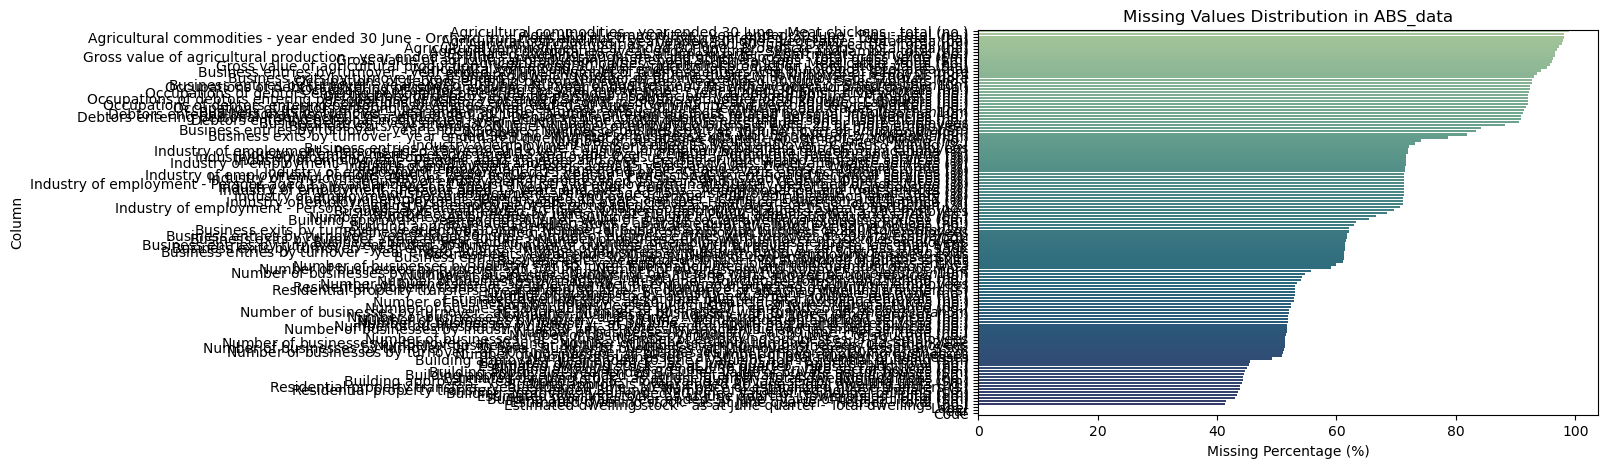

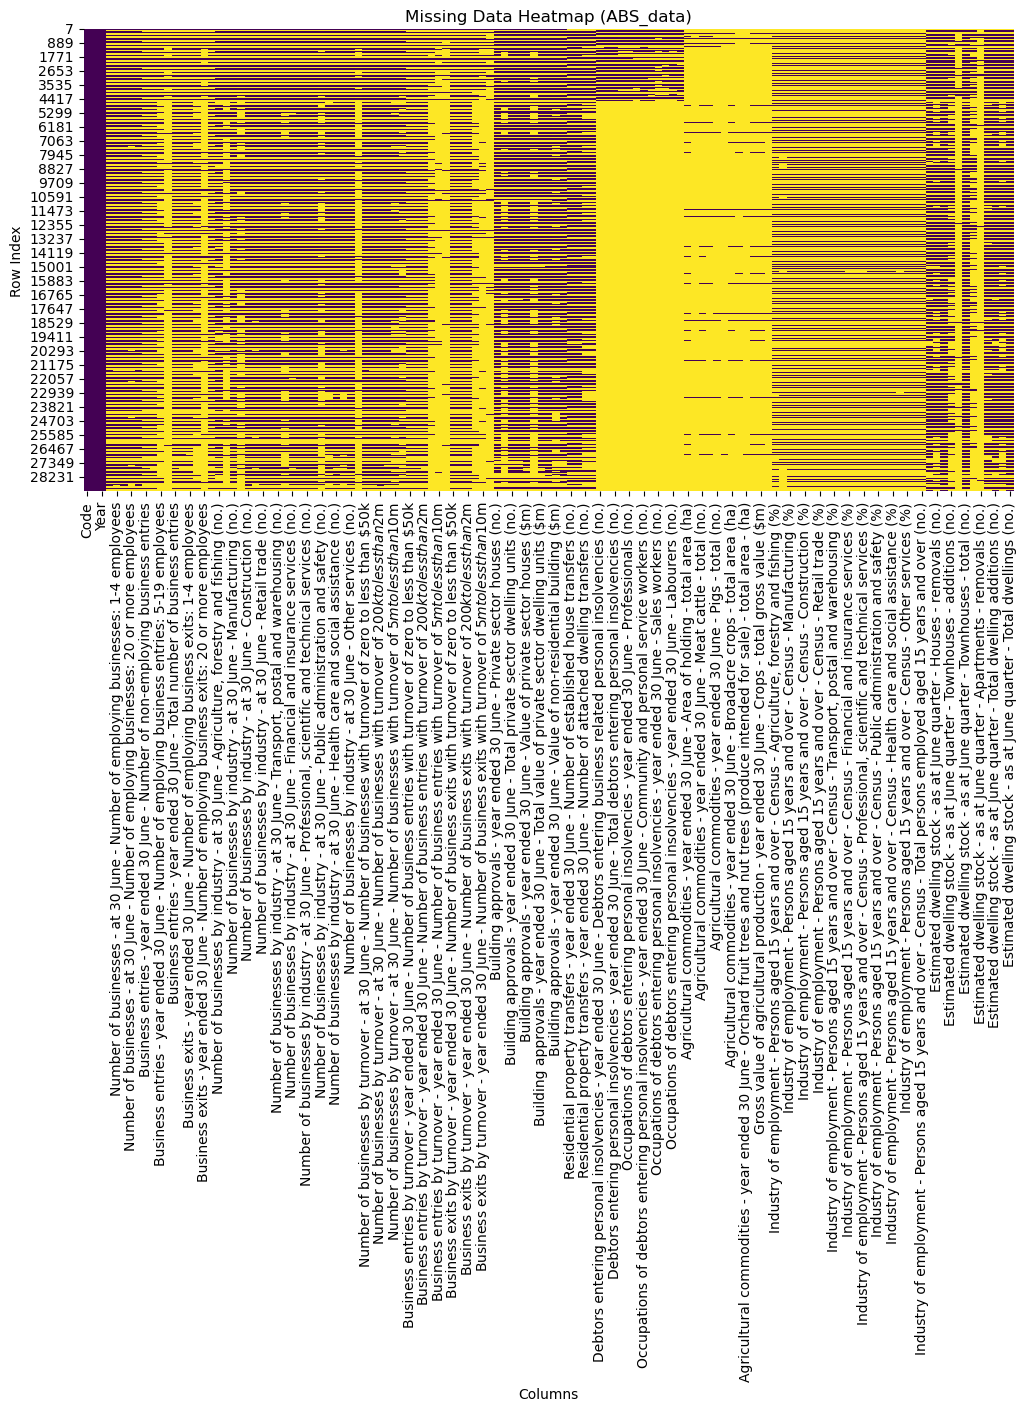

In [51]:
missing = (
    ABS_data.isna().sum()
    .reset_index()
    .rename(columns={"index": "column", 0: "missing_count"})
)
missing["missing_percent"] = (missing["missing_count"] / len(ABS_data) * 100).round(2)

# 只保留有缺失的列
missing = missing[missing["missing_count"] > 0]

print("=== 缺失值统计表 ===")
print(missing.sort_values("missing_percent", ascending=False))

# 2) 可视化：条形图展示缺失比例
plt.figure(figsize=(8, 5))
sns.barplot(
    data=missing.sort_values("missing_percent", ascending=False),
    x="missing_percent",
    y="column",
    palette="crest"
)
plt.xlabel("Missing Percentage (%)")
plt.ylabel("Column")
plt.title("Missing Values Distribution in ABS_data")
plt.show()

# 3) 可视化：缺失值分布热力图（行 x 列）
plt.figure(figsize=(12, 6))
sns.heatmap(ABS_data.isna(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap (ABS_data)")
plt.xlabel("Columns")
plt.ylabel("Row Index")
plt.show()

In [52]:
missing_ratio = ABS_data.isna().mean()  # 比例 0~1

# 2) 找到缺失比例 > 50% 的列
cols_to_drop = missing_ratio[missing_ratio > 0.50].index.tolist()

# 3) 删除这些列
ABS_data = ABS_data.drop(columns=cols_to_drop)



In [53]:
ABS_data.head(5)

,Code,Label,Year,Building approvals - year ended 30 June - Private sector houses (no.),Building approvals - year ended 30 June - Total private sector dwelling units (no.),Building approvals - year ended 30 June - Total dwelling units (no.),Building approvals - year ended 30 June - Value of private sector houses ($m),Building approvals - year ended 30 June - Total value of private sector dwelling units ($m),Building approvals - year ended 30 June - Value of residential building ($m),Building approvals - year ended 30 June - Value of non-residential building ($m),Building approvals - year ended 30 June - Value of total building ($m),Residential property transfers - year ended 30 June - Number of established house transfers (no.),Residential property transfers - year ended 30 June - Median price of established house transfers ($),Estimated dwelling stock - as at June quarter - Houses - additions (no.),Estimated dwelling stock - as at June quarter - Houses - total (no.),Estimated dwelling stock - as at June quarter - Townhouses - total (no.),Estimated dwelling stock - as at June quarter - Apartments - total (no.),Estimated dwelling stock - as at June quarter - Total dwelling additions (no.),Estimated dwelling stock - as at June quarter - Total dwellings (no.)
7,AUS,Australia,2011,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
8,AUS,Australia,2016,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9,AUS,Australia,2017,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,113258,7279135,1261457,1464325,218884,10022775
10,AUS,Australia,2018,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,319481,550000.0,113930,7371408,1293884,1530050,213652,10213246
11,AUS,Australia,2019,110689,185344,187751,42838,66887,69192,47331,116523,279464,545000.0,122142,7472853,1325743,1589770,215556,10406408


In [54]:
NGER_df=NGER_data
CER_df_powerStation=df_accredited
CER_df_project=df_committed_probable 
ABS_df=ABS_data

## Data Augmentation

In [56]:
#NGER的数据 NGER_df
#CER的数据 CER_df_powerStation
#CER的数据 CER_df_project
#ABS的数据 ABS_df

In [57]:
import os, time, json
import pandas as pd
import requests
from tqdm import tqdm

In [58]:
CER_df_powerStation.to_csv("CER_df_powerStation.csv", index=False)

In [59]:
import pandas as pd

df = CER_df_powerStation.copy()
print("行列规模：", df.shape)
print("全部列名：", list(df.columns))
display(df.head(3))

CANDS = {
    "name":     ["Facility Name","Station Name","Name","Power Station","PowerStation","facility_name"],
    "state":    ["State","state","State/Territory","Jurisdiction"],
    "suburb":   ["Suburb","City","Town","Locality","suburb"],
    "postcode": ["Postcode","postcode","Postal Code","ZIP","zip"],
    "address":  ["Address","Street Address","Site Address","location","Location"],
}
LAT_CANDS = ["lat","latitude","Latitude","LAT"]
LON_CANDS = ["lon","lng","longitude","Longitude","LON","LNG"]

def pick(df, options):
    for c in options:
        if c in df.columns:
            return c
    return None

picks = {k: pick(df, v) for k,v in CANDS.items()}
picks["lat"] = pick(df, LAT_CANDS)
picks["lon"] = pick(df, LON_CANDS)
print("\n自动识别到的列：", picks)

# 缺失率
for k, c in picks.items():
    if c:
        miss = df[c].isna().mean()
        print(f"{k:8s} -> {c:20s}  缺失率 {miss:.1%}")

def make_query(row):
    parts = []
    for key in ["address","name","suburb","state","postcode"]:
        col = picks.get(key)
        if col and pd.notna(row[col]):
            parts.append(str(row[col]).strip())
    parts.append("Australia")
    return ", ".join([p for p in parts if p])

sample = df.head(10).copy()
sample["query_preview"] = sample.apply(make_query, axis=1)
cols_show = [picks.get("name"), picks.get("suburb"), picks.get("state"),
             picks.get("postcode"), picks.get("address"), "query_preview"]
display(sample[ [c for c in cols_show if c] ])

行列规模： (280, 8)
全部列名： ['Accreditation code', 'Power station name', 'State', 'Postcode', 'Mw Capacity', 'Fuel Source', 'Accreditation start date', 'Approval date']


,Accreditation code,Power station name,State,Postcode,Mw Capacity,Fuel Source,Accreditation start date,Approval date
0,SRPXQLE8,"Laura Johnson Home, Townview - Solar w SGU - QLD",QLD,4825,0.2265,Solar,2024-10-15,2025-01-13
1,SRPYNS39,Leppington - Solar - NSW,NSW,2179,0.7320,Solar,2024-11-22,2025-01-13
2,SRPYNS58,Quakers Hillside Care Community - Solar w SGU ...,NSW,2763,0.1996,Solar,2024-12-19,2025-01-13



自动识别到的列： {'name': None, 'state': 'State', 'suburb': None, 'postcode': 'Postcode', 'address': None, 'lat': None, 'lon': None}
state    -> State                 缺失率 0.0%
postcode -> Postcode              缺失率 0.0%


,State,Postcode,query_preview
0,QLD,4825,"QLD, 4825, Australia"
1,NSW,2179,"NSW, 2179, Australia"
2,NSW,2763,"NSW, 2763, Australia"
3,VIC,3008,"VIC, 3008, Australia"
4,QLD,4074,"QLD, 4074, Australia"
5,QLD,4110,"QLD, 4110, Australia"
6,TAS,7249,"TAS, 7249, Australia"
7,SA,5113,"SA, 5113, Australia"
8,NSW,2092,"NSW, 2092, Australia"
9,SA,5106,"SA, 5106, Australia"


In [60]:
%pip install geopy tqdm pyarrow

import os, re, json
import pandas as pd
from tqdm.auto import tqdm
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.point import Point

# 参数 
USER_AGENT  = "COMP5339"   
COUNTRY     = "Australia"
CACHE_FILE  = "postcode_cache.jsonl"

# 州的近似边界框：(min_lon, min_lat, max_lon, max_lat)
STATE_VIEWBOX = {
    "NSW": (141.0, -37.6, 153.7, -28.0),
    "VIC": (141.0, -39.5, 150.0, -33.5),
    "QLD": (138.0, -29.5, 153.7, -10.5),
    "SA" : (129.0, -38.2, 141.5, -25.0),
    "WA" : (112.9, -35.5, 129.0, -13.5),
    "TAS": (144.0, -44.1, 149.5, -39.0),
    "NT" : (129.0, -26.0, 138.0, -10.0),
    "ACT": (148.7, -35.8, 149.4, -35.1),
}
def _vb_points(state):
    vb = STATE_VIEWBOX.get(state)
    if not vb: return None
    min_lon, min_lat, max_lon, max_lat = vb
    return [Point(min_lat, min_lon), Point(max_lat, max_lon)]  # geopy 需要 (lat, lon)

def _load_cache(path=CACHE_FILE):
    cache={}
    if os.path.exists(path):
        with open(path,"r",encoding="utf-8") as f:
            for line in f:
                try:
                    obj=json.loads(line); cache[obj["key"]]=obj
                except: pass
    return cache
def _save_cache(obj, path=CACHE_FILE):
    with open(path,"a",encoding="utf-8") as f:
        f.write(json.dumps(obj, ensure_ascii=False)+"\n")

# 1) 清洗 & 唯一 (State, Postcode)
df = CER_df_powerStation.copy()  
STATE_COL, POSTCODE_COL = "State", "Postcode"

df["State_clean"]    = df[STATE_COL].astype(str).str.upper().str.strip()
df["Postcode_clean"] = df[POSTCODE_COL].astype(str).str.extract(r"(\d{1,4})")[0].str.zfill(4)
df["_sp"]            = df["State_clean"] + "|" + df["Postcode_clean"]

pairs = df[["_sp","State_clean","Postcode_clean"]].drop_duplicates().reset_index(drop=True)
print("唯一 (State, Postcode) 组合数：", len(pairs))

# 2) (州,邮编) → 坐标（邮编质心）
geolocator = Nominatim(user_agent=USER_AGENT, timeout=10)
geocode    = RateLimiter(geolocator.geocode, min_delay_seconds=1.1, swallow_exceptions=True)

cache = _load_cache()
out = {}   

for _, r in tqdm(pairs.iterrows(), total=len(pairs), desc="Geocoding postcode centroids"):
    key   = r["_sp"]
    state = r["State_clean"]
    pc    = r["Postcode_clean"]

    if key in cache:
        out[key] = cache[key]; continue

    # L1：{postalcode, state, country} + 州界限框 + country_codes='au'
    kwargs = dict(exactly_one=True, addressdetails=True, country_codes="au")
    vb_pts = _vb_points(state)
    if vb_pts: kwargs.update(viewbox=vb_pts, bounded=True)

    loc = geocode({"postalcode": pc, "state": state, "country": COUNTRY}, **kwargs)

    # L2：仅 {postalcode, country}（仍为邮编质心）
    if loc is None:
        loc = geocode({"postalcode": pc, "country": COUNTRY},
                      exactly_one=True, addressdetails=True, country_codes="au")

    if loc:
        obj = {
            "key": key, "state": state, "postcode": pc,
            "lat": float(loc.latitude), "lon": float(loc.longitude),
            "source": "nominatim:postcode-centroid",
            "display_name": loc.raw.get("display_name","")
        }
    else:
        obj = {"key": key, "state": state, "postcode": pc,
               "lat": None, "lon": None, "source": "unresolved", "display_name": ""}

    _save_cache(obj); out[key] = obj

postcode_geo = pd.DataFrame(list(out.values()))
postcode_geo["_sp"] = postcode_geo["state"] + "|" + postcode_geo["postcode"]
assert postcode_geo["_sp"].is_unique, "右表出现重复邮编键，请检查。"

print(f"邮编地理编码成功：{postcode_geo['lat'].notna().sum()}/{len(postcode_geo)}")

# 3) 合并回整表 
merged = df.merge(
    postcode_geo[["_sp","lat","lon","source","display_name"]],
    on="_sp", how="left"
).copy()

merged["latitude_final"]  = merged["lat"]
merged["longitude_final"] = merged["lon"]
merged["geo_source"]      = merged["source"]
merged["geo_granularity"] = "postcode"

# 4) 验证
print("原始行数 vs 合并后行数：", len(df), len(merged))
assert len(df) == len(merged), "合并后行数不一致！"
miss = merged[["latitude_final","longitude_final"]].isna().any(axis=1).sum()
print("缺失坐标记录数：", miss); assert miss == 0, "仍有经纬度缺失！"
in_range = merged["latitude_final"].between(-44, -10) & merged["longitude_final"].between(112, 154)
print("大范围越界数：", (~in_range).sum()); assert in_range.all(), "有点超出澳洲范围，请检查！"
print("覆盖率与一致性检查通过。")

# 5) 导出 
#merged.to_csv("integrated_with_geo_postcode.csv", index=False)
#merged.to_parquet("integrated_with_geo_postcode.parquet", index=False)
#print("已导出：integrated_with_geo_postcode.(csv|parquet)")

Note: you may need to restart the kernel to use updated packages.
唯一 (State, Postcode) 组合数： 206


Geocoding postcode centroids:   0%|          | 0/206 [00:00<?, ?it/s]

邮编地理编码成功：206/206
原始行数 vs 合并后行数： 280 280
缺失坐标记录数： 0
大范围越界数： 0
覆盖率与一致性检查通过。


In [61]:
import json, pandas as pd

# 1) 关键指标
N_total   = len(merged)
N_pairs   = len(postcode_geo)
coverage  = merged[["latitude_final","longitude_final"]].notna().all(axis=1).mean()
src_counts = merged["geo_source"].value_counts(dropna=False)
gran_counts = merged["geo_granularity"].value_counts(dropna=False) if "geo_granularity" in merged.columns else pd.Series()

print("=== Data Augmentation Summary ===")
print(f"主表行数: {N_total}")
print(f"唯一 (State, Postcode) 组合数: {N_pairs}")
print(f"经纬度覆盖率: {coverage:.1%}\n")

print("来源分布(geo_source):")
display(src_counts.to_frame("count"))

if not gran_counts.empty:
    print("\n粒度分布(geo_granularity):")
    display(gran_counts.to_frame("count"))

# 2) 各州概览
by_state = (merged
    .groupby(merged["State"].astype(str).str.upper().str.strip())
    .agg(
        n=("State","size"),
        n_postcodes=("Postcode", lambda s: pd.Series(s).astype(str).str.extract(r"(\d{1,4})")[0].str.zfill(4).nunique()),
        lat_mean=("latitude_final","mean"),
        lon_mean=("longitude_final","mean")
    )
    .sort_values("n", ascending=False)
)
print("\n各州记录与唯一邮编数量:")
display(by_state)

# 3) 样例行
cols_show = ["Power station name","State","Postcode","latitude_final","longitude_final","geo_source"]
cols_show = [c for c in cols_show if c in merged.columns]
print("\n样例记录（随机10条）:")
display(merged.sample(10, random_state=42)[cols_show])


=== Data Augmentation Summary ===
主表行数: 280
唯一 (State, Postcode) 组合数: 206
经纬度覆盖率: 100.0%

来源分布(geo_source):


,count
geo_source,
nominatim:postcode-centroid,280



粒度分布(geo_granularity):


,count
geo_granularity,
postcode,280



各州记录与唯一邮编数量:


,n,n_postcodes,lat_mean,lon_mean
State,,,,
NSW,105,75,-33.526560,150.498091
QLD,70,47,-24.861265,150.881177
VIC,53,41,-37.589716,144.946765
SA,27,23,-34.889110,138.826139
WA,19,14,-31.362099,116.319423
TAS,4,4,-42.124960,147.047329
ACT,1,1,-35.595178,149.209594
NT,1,1,-12.498472,130.980498



样例记录（随机10条）:


,Power station name,State,Postcode,latitude_final,longitude_final,geo_source
33,Woolworths DC Moorebank RDC 7950 - Solar - NSW,NSW,2170,-33.931529,150.908958,nominatim:postcode-centroid
108,Petstock DC Avalon - Solar - VIC,VIC,3212,-38.029832,144.405385,nominatim:postcode-centroid
240,GRAC - Solar w SGU - VIC,VIC,3844,-38.196554,146.551200,nominatim:postcode-centroid
259,Dungog WTP - Solar - NSW,NSW,2420,-32.390582,151.722928,nominatim:postcode-centroid
154,PLASTIC SOLUTIONS - Solar w SGU - VIC,VIC,3179,-37.893959,145.227859,nominatim:postcode-centroid
9,Haighs Proprietary Limited - Salisbury South -...,SA,5106,-34.787119,138.639814,nominatim:postcode-centroid
146,St Gregory's College Hall - Solar - NSW,NSW,2557,-34.028349,150.775626,nominatim:postcode-centroid
203,Wambo Wind Farm Stage 1 - Wind - QLD,QLD,4410,-26.774109,151.114504,nominatim:postcode-centroid
144,Wollar Solar Farm-Solar-NSW,NSW,2850,-32.661815,149.631686,nominatim:postcode-centroid
155,Clarke Creek Wind Farm - Wind - QLD,QLD,4705,-22.779388,149.308480,nominatim:postcode-centroid


In [62]:
import folium
m = folium.Map(location=[-25.27,133.77], zoom_start=4)
for _, r in merged.iterrows():
    if pd.notna(r["latitude_final"]) and pd.notna(r["longitude_final"]):
        folium.CircleMarker([r["latitude_final"], r["longitude_final"]], radius=2).add_to(m)
m